In [1]:
from rtree import index
from copy import copy
import os
import xml.etree.ElementTree as ET
from copy import copy
from scipy import spatial
import numpy as np
import libtiff
from scipy import ndimage as nd
from matplotlib import pyplot as plt
import networkx as nx
import community
%matplotlib inline

In [222]:
Prox = {}

def spherical_trsf(pos):
    x, y, z = pos
    r = (x**2 + y**2 + z**2)**.5
    teta = np.arccos(z/r)
    phi = np.arctan(x/y)
    return r, teta, phi

# center_position = {
#     0: (400*4, 223*4, 129*4),
#     50: (378*4, 239*4, 131*4),
#     100: (406*4, 217*4, 129*4),
#     150: (394*4, 236*4, 126*4),
#     200: (377*4, 239*4, 131*4)
# }

# from matplotlib import cm
# mean_center = np.mean(center_position.values(), axis=0)
# mean_center[1] = 1100.

class CellSS(object):
    """docstring for CellSS:
        self.unique_id: id that is unique to the graph it is contained in
        self.id: id from the input data
        self.M: Mother of the """
    def __init__(self, unique_id, id, M, time, pos, D=None, N=None):
        self.unique_id = unique_id
        self.id = id
        self.time = time
        self.M = M
        if D is None:
            self.D = []
        else:
            self.D = D
        if N is None:
            self.N = []
        else:
            self.N = N
        self.pos = np.array(pos)

class LineageTree(object):
    """docstring for LineageTree"""


    def _dist_v(self, v1, v2):
        v1 = np.array(v1)
        v2 = np.array(v2)
        return np.sum((v1-v2)**2)**(.5)

    def copy_cell(self, C, links=[]):
        C_tmp = copy(C)
        self.nodes.append(C)


    def to_tlp(self, fname, t_min=-1, t_max=np.inf, temporal=True, spatial=False, VF=False):
        """
        Write a lineage tree into an understable tulip file
        fname : path to the tulip file to create
        lin_tree : lineage tree to write
        properties : dictionary of properties { 'Property name': [{c_id: prop_val}, default_val]}
        """
        
        f=open(fname, "w")

        f.write("(tlp \"2.0\"\n")
        f.write("(nodes ")
        if t_max!=np.inf or t_min>-1:
            nodes_to_use = [n for n in self.nodes if t_min<n.time<=t_max]
            edges_to_use = []
            if temporal:
                edges_to_use += [e for e in self.edges if t_min<e[0].time<t_max]
            if spatial:
                edges_to_use += [e for e in self.spatial_edges if t_min<e[0].time<t_max]
        else:
            nodes_to_use = self.nodes
            edges_to_use = []
            if temporal:
                edges_to_use += self.edges
            if spatial:
                edges_to_use += self.spatial_edges

        for n in nodes_to_use:
            f.write(str(n.unique_id)+ " ")
        f.write(")\n")

        for i, e in enumerate(edges_to_use):
            f.write("(edge " + str(i) + " " + str(e[0].unique_id) + " " + str(e[1].unique_id) + ")\n")
        f.write("(property 0 int \"id\"\n")
        f.write("\t(default \"0\" \"0\")\n")
        for n in nodes_to_use:
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.id) + "\")\n")
        f.write(")\n")

        f.write("(property 0 int \"time\"\n")
        f.write("\t(default \"0\" \"0\")\n")
        for n in nodes_to_use:
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.time) + "\")\n")
        f.write(")\n")

        f.write("(property 0 layout \"viewLayout\"\n")
        f.write("\t(default \"(0, 0, 0)\" \"()\")\n")
        for n in nodes_to_use:
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(tuple(n.pos)) + "\")\n")
        f.write(")\n")

        f.write("(property 0 double \"distance\"\n")
        f.write("\t(default \"0\" \"0\")\n")
        for i, e in enumerate(edges_to_use):
            d_tmp = self._dist_v(e[0].pos, e[1].pos)
            f.write("\t(edge " + str(i) + str(" \"") + str(d_tmp) + "\")\n")
            f.write("\t(node " + str(e[0].unique_id) + str(" \"") + str(d_tmp) + "\")\n")
        f.write(")\n")

        # for property in properties:
        #     prop_name=property[0]
        #     vals=property[1]
        #     default=property[2]
        #     f.write("(property 0 string \""+prop_name+"\"\n")
        #     f.write("\t(default \""+str(default)+"\" \"0\")\n")
        #     for node in nodes:
        #         f.write("\t(node " + str(node) + str(" \"") + str(vals.get(node, default)) + "\")\n")
        #     f.write(")\n") 
        f.write(")")
        f.close()

    def median_average(self, subset):
        subset_dist = [np.mean([di.pos for di in c.D], axis = 0) - c.pos for c in subset if c.D != []]
        target_C = [c for c in subset if c.D != []]
        if subset_dist != []:
            med_distance = spatial.distance.squareform(spatial.distance.pdist(subset_dist))
            return subset_dist[np.argmin(np.sum(med_distance, axis=0))]
        else:
            return [0, 0, 0]

    def median_average_bw(self, subset):
        subset_dist = [c.M.pos - c.pos for c in subset if c.M != self.R]
        target_C = [c for c in subset if c.D != []]
        if subset_dist != []:
            med_distance = spatial.distance.squareform(spatial.distance.pdist(subset_dist))
            return subset_dist[np.argmin(np.sum(med_distance, axis=0))]
        else:
            return [0, 0, 0]

    def build_median_vector(self, C, dist_th, delta_t = 2):#temporal_space=lambda d, t, c: d+(t*c)):
        if not hasattr(self, 'spatial_edges'):
            self.compute_spatial_edges(dist_th)
        subset = [C]
        subset += C.N
        added_D = added_M = subset
        for i in xrange(delta_t):
            _added_D = []
            _added_M = []
            for c in added_D:
                _added_D += c.D
            for c in added_M:
                if not c.M is None:
                    _added_M += [c.M]
            subset += _added_M
            subset += _added_D
            added_D = _added_D
            added_M = _added_M


        return self.median_average(subset)

    def build_vector_field(self, dist_th=50):
        ruler = 0
        for C in self.nodes:
            if ruler != C.time:
                print C.time
            C.direction = self.build_median_vector(C, dist_th)
            ruler = C.time

    def read_from_xml(self, file_format, tb, te, z_mult=1.):
        self.time = {}
        self.time_edges = {}
        unique_id = 0
        self.R = CellSS(-1, -1, None, -1, [-1]*3)
        self.nodes = []
        self.edges = []
        for t in range(tb, te+1):
            t_str = '%04d' % t
            tree = ET.parse(file_format.replace('$TIME$', t_str))
            root = tree.getroot()
            self.time[t] = {}
            self.time_edges[t] = []
            for it in root.getchildren():
                M_id, pos, cell_id = (int(it.attrib['parent']), 
                                      [float(v) for v in it.attrib['m'].split(' ') if v!=''], 
                                      int(it.attrib['id']))
                pos[-1] = pos[-1]*z_mult
                if self.time.get(t-1, {}).has_key(M_id):
                    M = self.time[t-1][M_id]
                    C = CellSS(unique_id, cell_id, M, t, pos)
                    M.D.append(C)
                    self.edges.append((M, C))
                    self.time_edges[t].append((M, C))
                else:
                    C = CellSS(unique_id, cell_id, self.R, t, pos)
                    self.R.D.append(C)

                self.nodes.append(C)
                self.time[t][cell_id] = C
                unique_id += 1
        self.max_id = unique_id - 1

    def build_VF_propagation(self, t_b=0, t_e=200, nb_max=20, dist_max=200):
        VF = LineageTree(None, None, None)
        VF.nodes = []
        VF.edges = []
        VF.R = CellSS(-1, -1, None, -1, None)
        starting_cells = self.time[t_b].values()
        unique_id = 0
        VF.time = {t_b: []}
        for i, C in enumerate(starting_cells):
            C_tmp = CellSS(unique_id=unique_id, id=unique_id, M=VF.R, time = t_b, pos = C.pos)
            VF.nodes.append(C_tmp)
            VF.time[t_b].append(C_tmp)
            unique_id+=1

        for t in range(t_b, t_e):
            p = index.Property()
            p.dimension = 3
            idx3d = index.Index(properties=p)
            to_check_self = self.time[t].values()
            to_check_VF = VF.time[t]
            for i, C in enumerate(to_check_self):
                idx3d.add(i, tuple(C.pos))
            print t
            VF.time[t+1] = []
            for C in to_check_VF:
                closest_cells = np.array(to_check_self)[list(idx3d.nearest(tuple(C.pos), nb_max))]
                max_value = np.min(np.where(np.array([self._dist_v(C.pos, ci.pos) for ci in closest_cells]+[dist_max+1])>dist_max))
                cells_to_keep = closest_cells[:max_value]
                med = self.median_average(cells_to_keep)
                C_next = CellSS(unique_id, unique_id, M=C, time = t+1, pos= C.pos + med)
                VF.time[t+1].append(C_next)
                C.D.append(C_next)
                # C.d_p = med
                VF.edges.append((C, C_next))
                VF.nodes.append(C_next)
                unique_id += 1
        VF.t_b = t_b
        VF.t_e = t_e
        return VF



    def build_VF_propagation_backward(self, t_b=0, t_e=200, nb_max=20, dist_max=200):
        VF = LineageTree(None, None, None)
        VF.nodes = []
        VF.edges = []
        VF.R = CellSS(-1, -1, None, -1, None)
        starting_cells = self.time[t_b].values()
        unique_id = 0
        VF.time = {t_b: []}
        for i, C in enumerate(starting_cells):
            C_tmp = CellSS(unique_id=unique_id, id=unique_id, M=VF.R, time = t_b, pos = C.pos)
            VF.nodes.append(C_tmp)
            VF.time[t_b].append(C_tmp)
            unique_id+=1

        if t_b>t_e : 
            increment = -1
        else: 
            increment = 1
        for t in range(t_b, t_e, -1):
            p = index.Property()
            p.dimension = 3
            idx3d = index.Index(properties=p)
            to_check_self = self.time[t].values()
            to_check_VF = VF.time[t]
            for i, C in enumerate(to_check_self):
                idx3d.add(i, tuple(C.pos))
            print t
            VF.time[t-1] = []
            for C in to_check_VF:
                closest_cells = np.array(to_check_self)[list(idx3d.nearest(tuple(C.pos), nb_max))]
                max_value = np.min(np.where(np.array([self._dist_v(C.pos, ci.pos) for ci in closest_cells]+[dist_max+1])>dist_max))
                cells_to_keep = closest_cells[:max_value]
                med = self.median_average_bw(cells_to_keep)
                C_next = CellSS(unique_id, unique_id, M=C, time = t-1, pos= C.pos + med)
                VF.time[t-1].append(C_next)
                C.D.append(C_next)
                # C.d_p = med
                VF.edges.append((C, C_next))
                VF.nodes.append(C_next)
                unique_id += 1
        VF.t_b = t_b
        VF.t_e = t_e
        return VF

    def compute_spatial_edges(self, th=50):
        self.spatial_edges=[]
        for t, Cs in self.time.iteritems():
            nodes_tmp, pos_tmp = zip(*[(C, C.pos) for C in Cs.itervalues()])
            nodes_tmp = np.array(nodes_tmp)
            distances = spatial.distance.squareform(spatial.distance.pdist(pos_tmp))
            nodes_to_match = np.where((0<distances) & (distances<th))
            to_link = zip(nodes_tmp[nodes_to_match[0]], nodes_tmp[nodes_to_match[1]])
            self.spatial_edges.extend(to_link)
            for C1, C2 in to_link:
                C1.N.append(C2)

    def __init__(self, file_format, tb, te, z_mult = .1):
        super(LineageTree, self).__init__()
        
        if not (file_format is None or tb is None or te is None):
            self.read_from_xml(file_format, tb, te, z_mult=z_mult)
            self.t_b = tb
            self.t_e = te


def reduce_graph(VF, t_b=None, t_e=None, reduction_scale=5):
    # import cPickle as pkl
    # f = open(p_to_VF)
    # VF = pkl.load(f)
    # f.close()
    if t_b is None:
        t_b = VF.t_b
    if t_e is None:
        t_e = VF.t_e

    VF_reduced = LineageTree(None, None, None)
    VF_reduced.nodes = []
    VF_reduced.edges = []
    VF_reduced.R = CellSS(-1, -1, None, -1, None)
    starting_cells = VF.time[t_b]
    unique_id = 0
    VF_reduced.time = {t_b: []}
    for i, C in enumerate(starting_cells):
        C_tmp = CellSS(unique_id=unique_id, id=unique_id, M=VF_reduced.R, D=copy(C.D), time = t_b, pos = C.pos)
        VF_reduced.nodes.append(C_tmp)
        VF_reduced.time[t_b].append(C_tmp)
        unique_id+=1

    for t in xrange(t_b, t_e, reduction_scale):
        VF_reduced.time[t+reduction_scale] = []
        for C in VF_reduced.time[t]:
            C_tmp = copy(C)
            for i in range(np.abs(reduction_scale)):
                if len(C_tmp.D)!=0:
                    C_tmp = copy(C_tmp.D[0])
            C_to_add = CellSS(unique_id, unique_id, M=C, D=C_tmp.D, time = t+reduction_scale, pos = C_tmp.pos)
            VF_reduced.time[t+reduction_scale].append(C_to_add)
            C.D = [C_to_add]
            VF_reduced.edges.append((C, C_to_add))
            VF_reduced.nodes.append(C_to_add)
            unique_id += 1
    return VF_reduced

def dist_v(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.sum((v1-v2)**2)**(.5)

def conn_G_to_tlp(fname, b_g):

    nodes_to_use = b_g.keys()
    tmp_edges = [(k, vi) for k, v in b_g.iteritems() for vi in v]

    f=open(fname, "w")

    f.write("(tlp \"2.0\"\n")

    f.write("(nodes ")
    for n in nodes_to_use:
        f.write(str(n.unique_id)+ " ")
    f.write(")\n")

    for i, e in enumerate(tmp_edges):
        f.write("(edge " + str(i) + " " + str(e[0].unique_id) + " " + str(e[1].unique_id) + ")\n")
    
    f.write("(property 0 int \"id\"\n")
    f.write("\t(default \"0\" \"0\")\n")
    for n in nodes_to_use:
        f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.id) + "\")\n")
    f.write(")\n")

    # f.write("(property 0 int \"time\"\n")
    # f.write("\t(default \"0\" \"0\")\n")
    # for n in nodes_to_use:
    #     f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.time) + "\")\n")
    # f.write(")\n")

    f.write("(property 0 layout \"viewLayout\"\n")
    f.write("\t(default \"(0, 0, 0)\" \"()\")\n")
    for n in nodes_to_use:
        f.write("\t(node " + str(n.unique_id) + str(" \"") + str(tuple(n.pos)) + "\")\n")
    f.write(")\n")

    f.write("(property 0 double \"distance\"\n")
    f.write("\t(default \"0\" \"0\")\n")
    for i, e in enumerate(tmp_edges):
        f.write("\t(edge " + str(i) + str(" \"") + str(dist_v(e[0].pos, e[1].pos)) + "\")\n")    
    f.write(")\n")

    f.write("(property 0 int \"P\"\n")
    f.write("\t(default \"0\" \"0\")\n")
    for n in nodes_to_use:
        if hasattr(n, 'P'):
            f.write("\t(node " + str(n.unique_id) + str(" \"") + str(n.P) + "\")\n")
    f.write(")\n")

    f.write(")")
    f.close()

In [3]:
path_to_files = 'D:\Users\Leo\FernandoTGMMRuns\GMEMtracking3D_2015_3_6_17_42_12_Drosophila_12_08_28_trainCDWT_iter5\XML_finalResult_lht'

LT = LineageTree(file_format = path_to_files + '\GMEMfinalResult_frame$TIME$.xml', tb = 0, te = 300, z_mult = 5.)

C:\Users\Leo\Anaconda2\lib\site-packages\ipykernel\__main__.py:188: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


In [4]:
VF = LT.build_VF_propagation_backward(t_b = 300, t_e = 0, nb_max = 50)

300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244
243
242
241
240
239
238
237
236
235
234
233
232
231
230
229
228
227
226
225
224
223
222
221
220
219
218
217
216
215
214
213
212
211
210
209
208
207
206
205
204
203
202
201
200
199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
3

In [5]:
VF_R = reduce_graph(VF, reduction_scale=-5)
VF_R.to_tlp('VF_R_bw.tlp')

VF_R_tmp = copy(VF_R)
Neighbs = {}
max_N = 20
dist_max = 80
for t, Cs in VF_R_tmp.time.iteritems():
    print t
    p = index.Property()
    p.dimension = 3
    idx3d = index.Index(properties=p)
    if not Prox.has_key(t):
        for i, C in enumerate(Cs):
            idx3d.add(i, tuple(C.pos))
        Prox[t] = idx3d
    else:
        idx3d = Prox[t]
    for i, C in enumerate(Cs):
        closest_cells = np.array(Cs)[list(idx3d.nearest(tuple(C.pos), max_N))]
        max_value = np.min(np.where(np.array([VF_R_tmp._dist_v(C.pos, ci.pos) for ci in closest_cells]+[dist_max+1])>dist_max))
        to_add = list(closest_cells[1:max_value])
        C.N = to_add
        for Cn in list(closest_cells[1:max_value]):
            VF_R_tmp.edges.append((C, Cn))


built_graph = {}
t= 200
for C_tb in VF_R_tmp.time[t]:
    N_tb = C_tb.N
    N_tmp = C_tb.N
    while N_tmp != []:
        N_te = N_tmp
        N_tmp = [n for N in N_tmp for n in N.D]
    C_te = C_tb
    while C_te.D != []:
        C_te = C_te.D[0]
    built_graph[C_te] = list(set(C_te.N).intersection(N_te))

0
130
260
5
135
265
10
140
270
15
145
275
20
150
280
25
155
285
30
160
290
35
165
295
40
170
300
45
175
50
180
55
185
60
190
65
195
70
200
75
205
80
210
85
215
90
220
95
225
100
230
105
235
110
240
115
245
120
250
125
255


In [6]:
VF_R = VF_R_tmp

corres_table = {c.unique_id: c for c in built_graph.keys()}

G = nx.Graph()

for k, v in built_graph.iteritems():
    for vi in v:
        G.add_edge(k.unique_id, vi.unique_id)

partition = community.best_partition(G)

for id_, p in partition.iteritems():
    corres_table[id_].P = p

for id_, P in partition.iteritems():
    C_next = corres_table[id_]
    while C_next != VF_R.R:
        C_next.P = P
        C_next = C_next.M

conn_G_to_tlp('connexity_bw.tlp', built_graph)
VF_R.to_tlp(path_to_files + '\VF_R_bw.tlp')

In [348]:
from sklearn.decomposition import PCA
from scipy.ndimage import filters as filters


def coordinates_rotation(coord, teta):
    rot_m = np.array([
            [np.cos(teta), -np.sin(teta), 0],
            [np.sin(teta),  np.cos(teta), 0],
            [           0,             0, 1],
        ])
    return np.dot(rot_m, coord)

point_set = np.array([C.pos[:2] for C in VF_R.nodes])
b = np.mean(point_set, axis = 0)
barycenter = [b[0], b[1], 0]
tmp = PCA()
tmp.fit(point_set)
teta = np.arccos(tmp.components_[0][0])

for C in VF_R.nodes:
    C.Npos = coordinates_rotation(C.pos-barycenter, -teta) + barycenter

In [354]:
from sklearn.decomposition import PCA
from scipy.ndimage import filters as filters

cc = list(nx.connected_components(G))
to_keep = cc[np.argmax([len(c) for c in cc])]
Cells = []
dteta_in_time = []
dphi_in_time = []
dr_in_time = []
corres_cell_dist_mat = {}
i = 0
for C in VF_R.time[0]:
    Cells += [C]
    corres_cell_dist_mat[C.unique_id] = i
    i += 1
#         positions = [C.pos]
    positions_sphere = [spherical_trsf(C.Npos)]
    actual = C.M
    for t in range(5, 301, 5):
#             positions += [actual.pos]
        positions_sphere += [spherical_trsf(actual.pos - mean_center)]
        if actual.M != VF_R.R:
            actual = actual.M
    positions_sphere = np.array(positions_sphere)
#         r_smoothed = filters.median_filter(positions_sphere[:,0])
#         teta_smoothed = filters.median_filter(positions_sphere[:,1], 2)
    teta_smoothed = positions_sphere[:,1]
    phi_smoothed = positions_sphere[:,2]
    r_smoothed = positions_sphere[:,0]
#         phi_smoothed = filters.median_filter(positions_sphere[:,2])
    to_take = np.argmin([np.abs(teta_smoothed[1:] - teta_smoothed[:-1]), 
                         np.abs(teta_smoothed[1:] - (np.pi + teta_smoothed[:-1])),
                         np.abs(teta_smoothed[1:] - (teta_smoothed[:-1] - np.pi))], axis=0)
    dteta_in_time += [np.array([teta_smoothed[1:] - teta_smoothed[:-1], 
                                teta_smoothed[1:] - (np.pi + teta_smoothed[:-1]),
                                teta_smoothed[1:] - (teta_smoothed[:-1] - np.pi)])[to_take, range(len(to_take))][5:31]]
#     [list(np.min([teta_smoothed[1:] - teta_smoothed[:-1], teta_smoothed[1:] - np.pi-teta_smoothed[:-1]], axis=2))]
    
    to_take = np.argmin([np.abs(phi_smoothed[1:] - phi_smoothed[:-1]), 
                         np.abs(phi_smoothed[1:] - (np.pi + phi_smoothed[:-1])),
                         np.abs(phi_smoothed[1:] - (phi_smoothed[:-1] - np.pi))], axis=0)
    dphi_in_time += [np.array([phi_smoothed[1:] - phi_smoothed[:-1], 
                                phi_smoothed[1:] - (np.pi + phi_smoothed[:-1]),
                                phi_smoothed[1:] - (phi_smoothed[:-1] - np.pi)])[to_take, range(len(to_take))][5:31]]
#     dphi_in_time += [list(phi_smoothed[1:] - phi_smoothed[:-1])]
    dr_in_time += [list(r_smoothed[1:] - r_smoothed[:-1])]

In [116]:
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import pearsonr as P
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as H


def build_linkage(tables):
#     table = np.array(table)
    dist_m = np.array([squareform(pdist(np.array(t), 'euclidean')) for t in tables])
    dist_m = np.average(dist_m, axis = 0)
    
    final_dist = dist_m.copy()
    for c1, c2 in G.edges_iter():
        if corres_cell_dist_mat.has_key(c1) and corres_cell_dist_mat.has_key(c2):
            final_dist[corres_cell_dist_mat[c1], 
                       corres_cell_dist_mat[c2]] = dist_m[corres_cell_dist_mat[c1], 
                                                          corres_cell_dist_mat[c2]]/2.
            final_dist[corres_cell_dist_mat[c2], 
                       corres_cell_dist_mat[c1]] = dist_m[corres_cell_dist_mat[c2], 
                                                          corres_cell_dist_mat[c1]]/2.

    final_dist[np.diag_indices(final_dist.shape[0])] = 0

    return H.linkage(squareform(final_dist), method='average')

In [357]:
Y_d_teta = build_linkage([dteta_in_time])
# Y_d_phi = build_linkage(dphi_in_time)
# Y_d_r = build_linkage(dr_in_time)
# tmp=H.dendrogram(Y_d_teta, no_plot=True)
# tmp=H.dendrogram(Y_d_teta, p=30, truncate_mode='lastp')
# final_dist_ordered = np.zeros_like(final_dist)
# final_dist_ordered = final_dist[:, tmp['leaves']]
# final_dist_ordered = final_dist_ordered[tmp['leaves'], :]

# fig=plt.figure(figsize=(20, 20))

# ax=fig.add_subplot(111)
# ax.matshow(final_dist_ordered, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
# # ax.imshow(final_dist_ordered, interpolation='nearest')
# plt.savefig(path_to_files + '\\test_d_teta.pdf')
# plt.close()

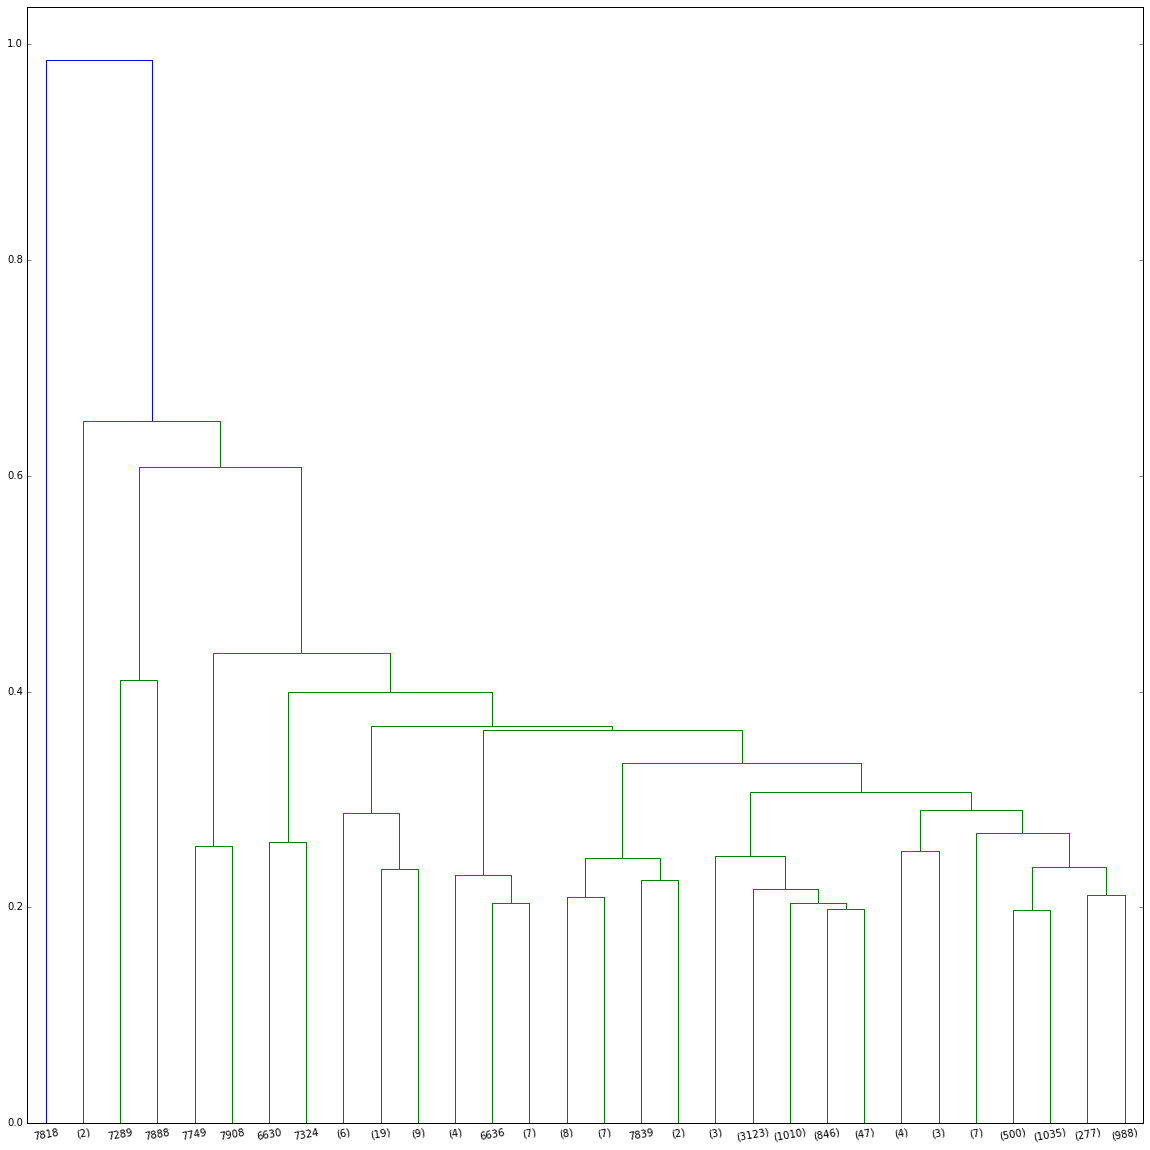

In [358]:
fig=plt.figure(figsize=(20, 20))
tmp=H.dendrogram(Y_d_teta, p=30, truncate_mode='lastp')

In [ ]:
gc.collect()

In [ ]:
import gc
gc.collect()
path_to_folder = path_to_files + '\VFYZ_test\\'
import os
if not os.path.exists(path_to_folder):
    os.makedirs(path_to_folder)
P_mv = 30
mean_center = np.array([600, 300, 300])
p_1 = 0
p_2 = 1
p_3 = 2
# starting_cells = starting_cells_to_keep
t=0
min_=0
max_=2200
min_ = 2*np.pi
max_ = 0
import colorsys
# for i, C in enumerate(VF_R.time[0]):
#     min_ = min(spherical_trsf(C.M.pos - mean_center)[2], min_)
#     max_ = max(spherical_trsf(C.M.pos - mean_center)[2], max_)
# for i, C in enumerate(VF_R.time[0]):
#     pos_c = colorsys.hsv_to_rgb((spherical_trsf(C.M.pos - mean_center)[2]-min_)/(max_-min_), 1., 1.)
#     C.pos_c = pos_c
#     C_next = C.M
#     while C_next != VF_R.R:
#         C_next.pos_c = pos_c
#         C_next = C_next.M

# out = H.fcluster(Y_d_teta, P_mv, 'maxclust')
# for i, C in enumerate(Cells):
#     C.P=out[i]
#     C_next = C.M
#     while C_next != VF_R.R:
#         C_next.P = out[i]
#         C_next = C_next.M

trsf = 600
starting_cells = VF_R.time[0][::3]
for t in range(0, 300, 5):#
    print t
#     for R in range(500, 2000, 50):
#     to_check = [C for C in VF_R.time[t][::4] if not C.P is None and np.log2(C.P)>4]#VF_R.time[t][::4]
#     to_check += [C for C in LT.time[t].itervalues() if R<C.Npos[0]<R+100]
    #[::4]#starting_cells#[C for C in VF_R.time[t][::4] if 2300<C.Npos[2]<2600 or C in next_cells]
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    next_cells = []
    
    for C in starting_cells:#VF_R.time[t][::3]:#to_check:#
        if C != VF_R.R:
            i=0
            alpha = max(0, 1-(C.Npos[p_3])/(350.))
            col = C.pos_c
            if hasattr(C, 'P'):
                D = np.float(C.P)#spherical_trsf(C.M.Npos - mean_center)[2] - spherical_trsf(C.Npos - mean_center)[2]
            else:
                D = P_mv+1
            col = cm.Accent(min(D/(P_mv+1), 1.))
    #         if C in LT.time[t].values():
    #             col = (0., 1., 0., 1.)
    #         elif C.P is None:
    #             col = (1., 0., 0., 1.)
            actual = C
            next_ = C.M
            next_cells.append(actual.M)
            alpha_other = max(0, (C.Npos[p_3]-300)/(350.))
            while next_.M != VF_R.R and i<4:
                i+=1
                ax.arrow((actual.Npos[p_1]), (actual.Npos[p_2]), (next_.Npos[p_1]-(actual.Npos[p_1])), 
                         ((next_.Npos[p_2])-(actual.Npos[p_2])), alpha=alpha, color=col)
                ax.arrow((actual.Npos[p_1]), (actual.Npos[p_2]+trsf), (next_.Npos[p_1]-(actual.Npos[p_1])), 
                         ((next_.Npos[p_2])-(actual.Npos[p_2])), alpha=alpha_other, color=col)
                actual = next_
                next_ = next_.M
            ax.plot((actual.Npos[p_1]), (actual.Npos[p_2]), 'o', alpha = alpha, 
                    markersize=5, color=col, mec = col)
            ax.plot((actual.Npos[p_1]), (actual.Npos[p_2]+trsf), 'o', alpha = alpha_other, 
                    markersize=5, color=col, mec = col)
            
    starting_cells = next_cells
    ax.set_xlim(-100, 1400)
#     ax.set_ylim(0, 2000)
    ax.set_ylim(-100, 1400)
    fig.savefig(path_to_folder + 'time%04d.png'%t)
    plt.close()
    gc.collect()
    

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260

In [ ]:
gc.collect()

tmp


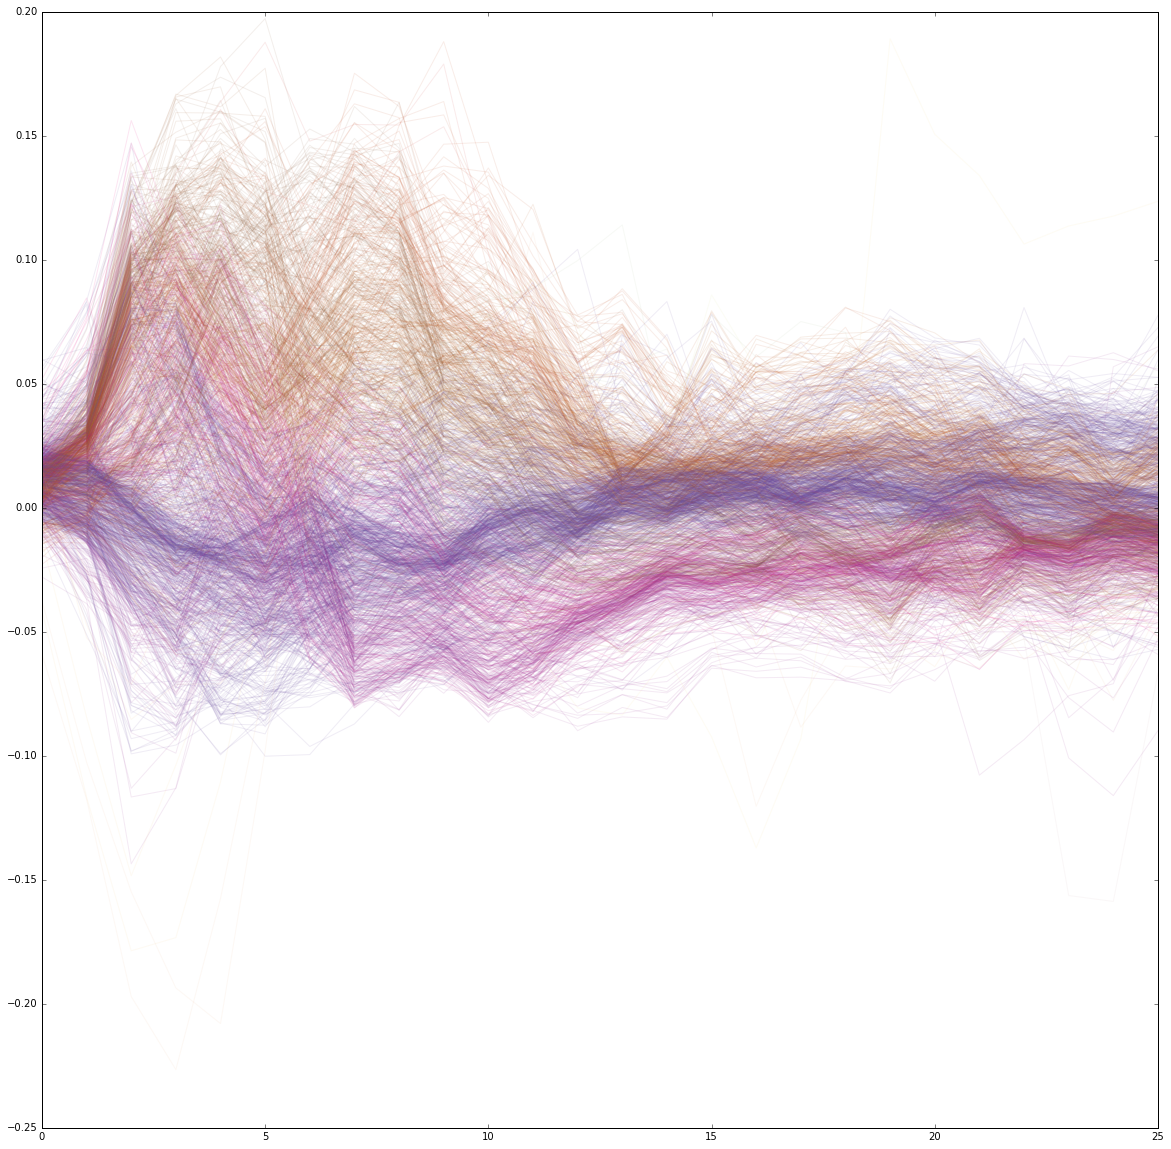

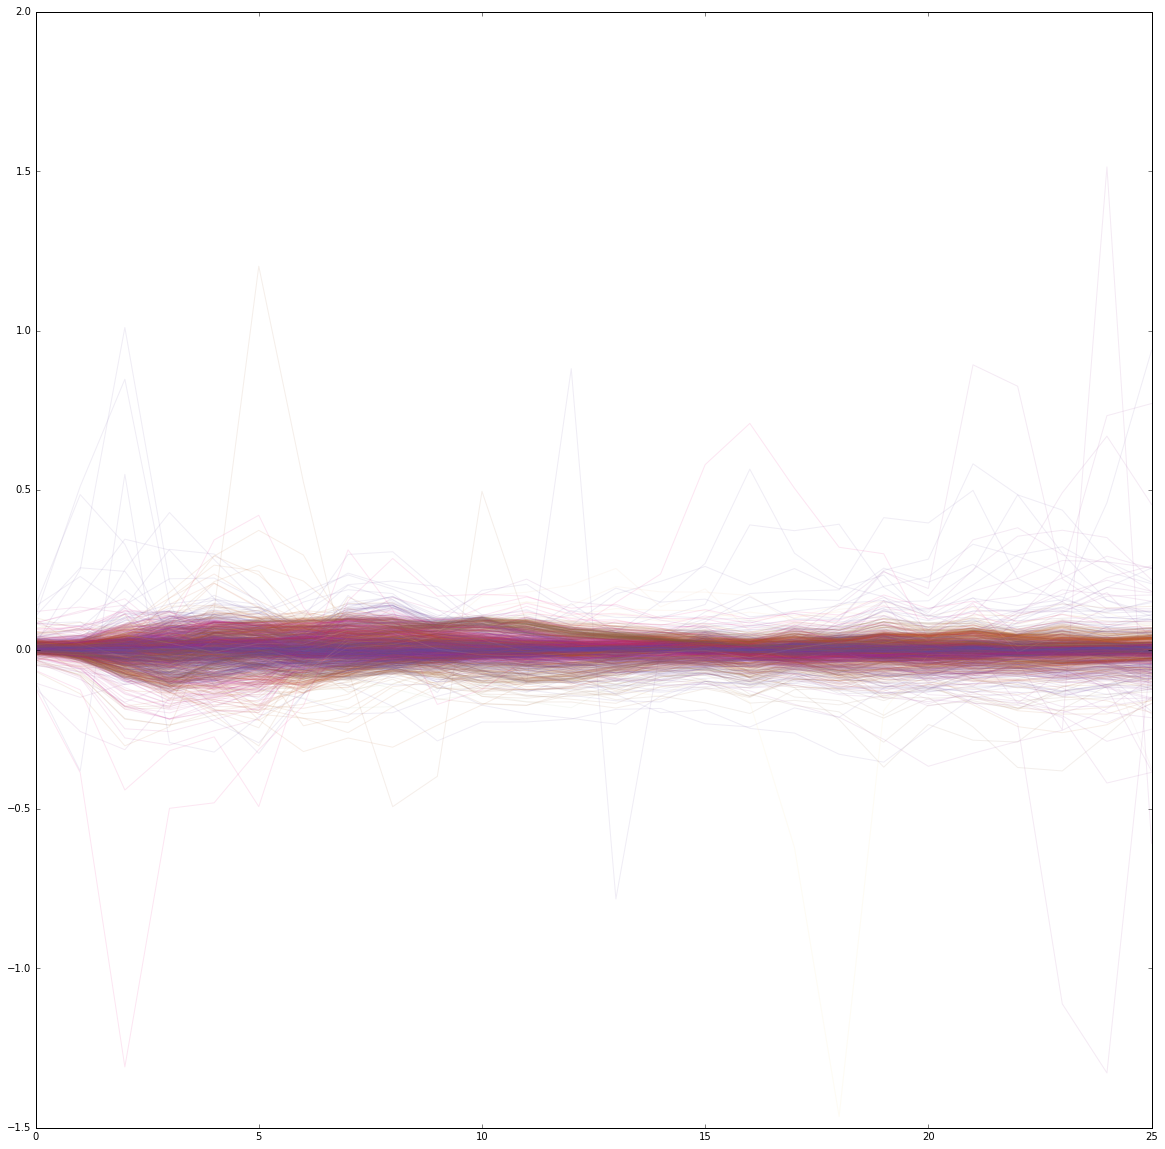

In [356]:
P_mv = 30


out = H.fcluster(Y_d_teta, P_mv, 'maxclust')
for i, C in enumerate(Cells):
    C.P=out[i]
    C_next = C.M
    while C_next != VF_R.R:
        C_next.P = out[i]
        C_next = C_next.M


out = H.fcluster(Y_d_teta, P_mv, 'maxclust')
plt.figure(figsize=(20, 20))
# plt.hist(out, range=(0, P_mv), bins=P_mv)
# plt.plot(np.array(np.cumsum(dr_in_time[::5], axis=1)).T, alpha=.1)
for i, d in enumerate(dteta_in_time[::5]):
    col = cm.Accent(min(VF_R.time[0][::5][i].P/float(P_mv+1), 1.))
    plt.plot((d), alpha=.1, color = col)

plt.figure(figsize=(20, 20))
for i, d in enumerate(dphi_in_time[::5]):
    col = cm.Accent(min(VF_R.time[0][::5][i].P/float(P_mv+1), 1.))
    plt.plot((d), alpha=.1, color = col)
# plt.ylim(-.3, .3)

# plt.figure(figsize=(20, 20))
# # plt.hist(out, range=(0, P_mv), bins=P_mv)
# plt.plot(np.array(np.cumsum(dphi_in_time[::5], axis=1)).T, alpha=.1)

# plt.figure(figsize=(20, 20))
# # plt.hist(out, range=(0, P_mv), bins=P_mv)
# plt.plot(np.array(np.cumsum(dteta_in_time[::5], axis=1)).T, alpha=.1)


print 'tmp'

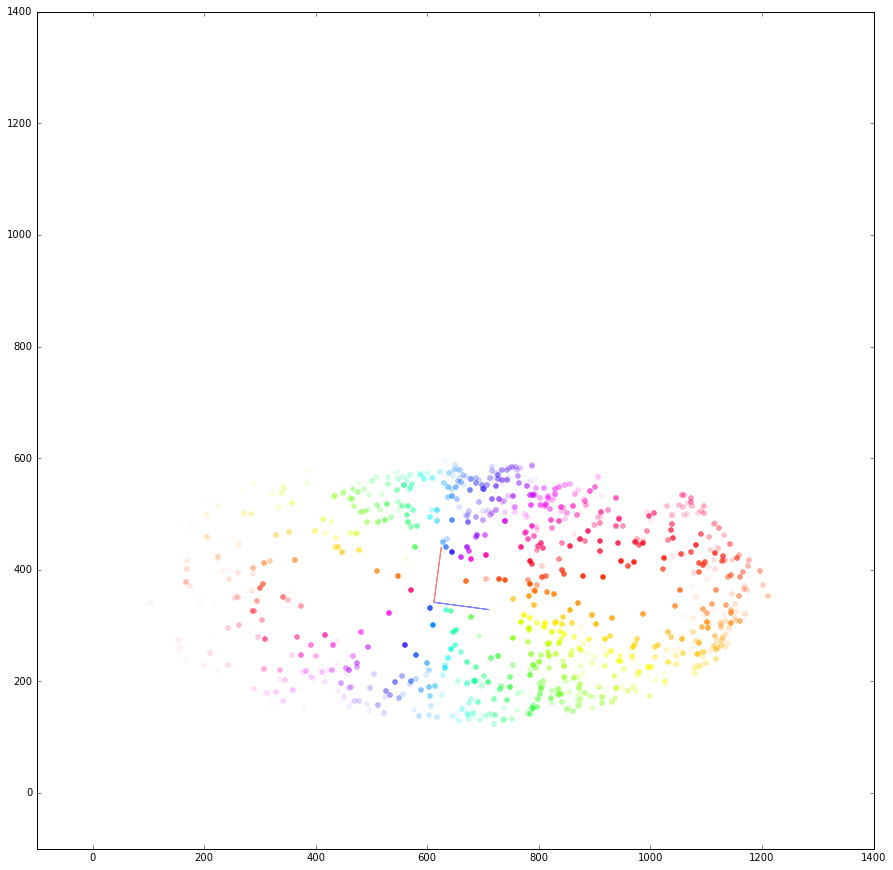

In [353]:
from sklearn.decomposition import PCA
from scipy.ndimage import filters as filters


def coordinates_rotation(coord, teta):
    rot_m = np.array([
            [np.cos(teta), -np.sin(teta), 0],
            [np.sin(teta),  np.cos(teta), 0],
            [           0,             0, 1],
        ])
    return np.dot(rot_m, coord)

point_set = np.array([C.pos[:2] for C in VF_R.nodes])
b = np.mean(point_set, axis = 0)
barycenter = [b[0], b[1], 0]
tmp = PCA()
tmp.fit(point_set)
teta = np.arccos(tmp.components_[0][0])

for C in VF_R.nodes:
    C.Npos = coordinates_rotation(C.pos-barycenter, -teta) + barycenter
    


fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
for C in starting_cells:#VF_R.time[t][::3]:#to_check:#
    if C != VF_R.R:
        i=0
        alpha = max(0, 1-(C.pos[p_3])/(350.))
        col = C.pos_c
        actual = C
        next_ = C.M
        next_cells.append(actual.M)
        new_pos = C.Npos
        ax.plot((new_pos[p_1]), (new_pos[p_2]), 'o', alpha = alpha, 
                markersize=5, color=col, mec = col)
        j+=5
#         ax.plot(mean_center[0], mean_center[1], 'ko', markersize=5)
ax.set_xlim(-100, 1400)
# #     ax.set_ylim(0, 2000)
ax.set_ylim(-100, 1400)
# ax.plot(bary_center[0], bary_center[1], 'o', markersize=10)

# ax.plot(barycenter[0], barycenter[1], 'o', markersize=10)

ax.arrow(barycenter[0], barycenter[1], 100*test.components_[0][0],  100*test.components_[1][0],
         color='b', alpha=.5)
ax.arrow(barycenter[0], barycenter[1], -100*test.components_[0][1],  -100*test.components_[1][1],
         color='r', alpha=.5)

# ax.set_xlim(560, 570)
# ax.set_ylim(340, 350)

#     ax.set_ylim(0, 2000)

In [301]:
len(starting_cells), len(new_point_set[::5])

(1584, 1584)

In [ ]:
gc.collect()
